In [1]:
import json
import sys
sys.path.append('/Users/wastechs/Documents/git-repos/energy-efficiency')
from validation.gp.create_train_inference import create_train_inference_gp
from lib.util import helper, data_preprocessing
import torch
import gpytorch

### 30 minutes agg.

In [12]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='gesamtmessung_30T', 
    freq=30,
    normalize_time=True
    )

In [3]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.06, 0.10) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.20, 0.23) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha

covar_module1 = locally_short_periodic + locally_long_periodic + local_variation 
covar_module2 = locally_short_periodic
covar_module3 = locally_short_periodic + local_variation 
covar_module4 = locally_short_periodic + locally_long_periodic

covar_module5 = locally_long_periodic
covar_module6 = locally_long_periodic + local_variation 

covar_module7 = local_variation

covar_combinations = [
    covar_module1, covar_module2, covar_module3, 
    covar_module4, covar_module5, covar_module6, 
    covar_module7]

### Create, Train, and Perform Inference

In [ ]:
for kernel in covar_combinations:
    X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='gesamtmessung_30T', 
    freq=30,
    normalize_time=True)
    
    func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
        kernel_gen=kernel,
        train_x=X_train,
        train_y=y_train,
        test_x=X_test,
        test_y=y_test,
        n_train=n_train,
        time_agg='30T',
        training_iter=100,
        lr=0.1,
        machine='gesamtmessung',
        update_score=True
    )

In [ ]:
mse, mape

Iter 1 , Loss = 0.9656256162262564 , Noise = 0.6932471990585327
Iter 2 , Loss = 0.9283600657010976 , Noise = 0.6444966793060303
Iter 3 , Loss = 0.8924482392946599 , Noise = 0.5982195138931274
Iter 4 , Loss = 0.8579912407352936 , Noise = 0.5543935298919678
Iter 5 , Loss = 0.8249131778662968 , Noise = 0.5129909515380859
Iter 6 , Loss = 0.7929062493254123 , Noise = 0.4739769399166107
Iter 7 , Loss = 0.7615039832241971 , Noise = 0.43730899691581726
Iter 8 , Loss = 0.7303154071500638 , Noise = 0.4029351472854614
Iter 9 , Loss = 0.6991443411725154 , Noise = 0.3707936406135559
Iter 10 , Loss = 0.6679328647406325 , Noise = 0.3408133387565613
Iter 11 , Loss = 0.6367030202825796 , Noise = 0.3129146993160248
Iter 12 , Loss = 0.6055573163628167 , Noise = 0.2870117425918579
Iter 13 , Loss = 0.5746973161627308 , Noise = 0.2630140781402588
Iter 14 , Loss = 0.5444096284946836 , Noise = 0.24082937836647034
Iter 15 , Loss = 0.514996386275057 , Noise = 0.22036491334438324
Iter 16 , Loss = 0.4866753345555

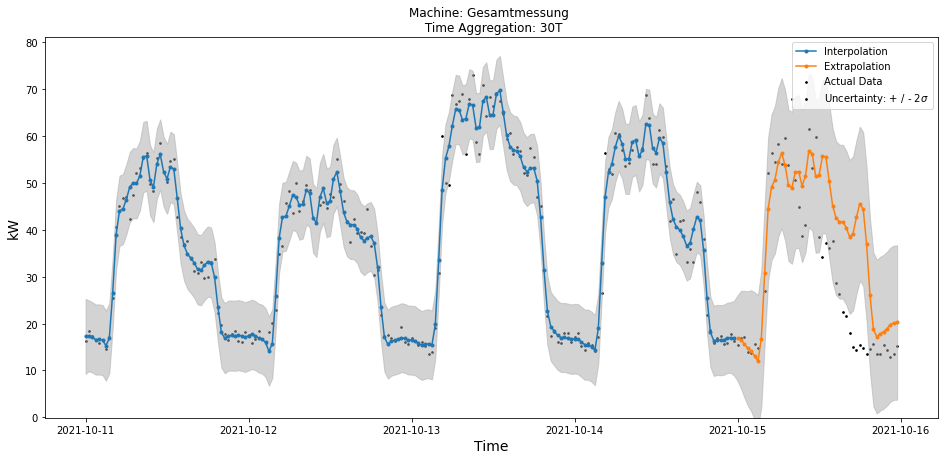

                 time     actual        machine
0 2021-10-13 04:30:00  60.024934  Gesamtmessung
1 2021-10-14 04:30:00  56.487998  Gesamtmessung


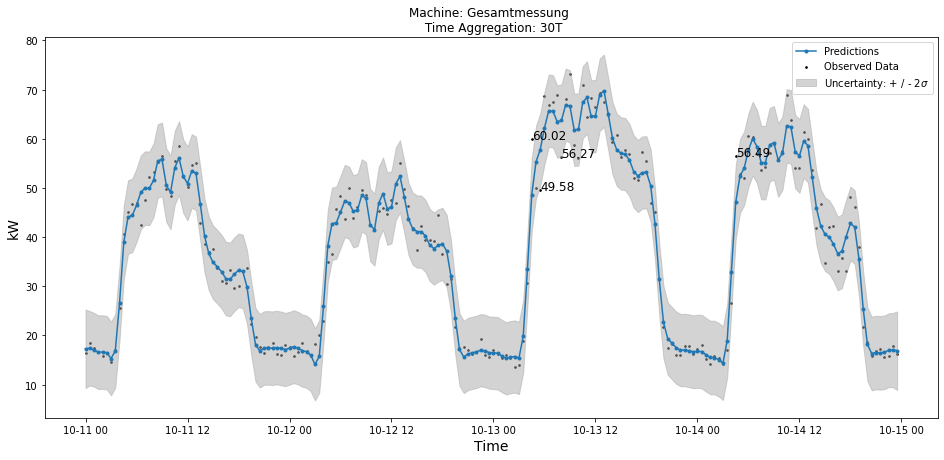

    index                time        machine control_limit  actual_kw  \
0       0 2021-10-15 08:00:00  Gesamtmessung         upper  67.989351   
1       0 2021-10-15 12:30:00  Gesamtmessung         lower  34.241928   
2       1 2021-10-15 13:00:00  Gesamtmessung         lower  37.139723   
3       2 2021-10-15 15:30:00  Gesamtmessung         lower  22.564209   
4       3 2021-10-15 16:00:00  Gesamtmessung         lower  21.551631   
5       4 2021-10-15 16:30:00  Gesamtmessung         lower  18.026375   
6       5 2021-10-15 17:00:00  Gesamtmessung         lower  15.102880   
7       6 2021-10-15 17:30:00  Gesamtmessung         lower  14.387217   
8       7 2021-10-15 18:00:00  Gesamtmessung         lower  15.374839   
9       8 2021-10-15 18:30:00  Gesamtmessung         lower  14.774898   
10      9 2021-10-15 19:00:00  Gesamtmessung         lower  13.422571   

    expected_kw      bound  
0     48.957402  65.156495  
1     55.669315  39.269854  
2     55.597478  39.191158  
3     4

/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:516: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[upper], deviation[upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:517: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[lower], deviation[lower], color='red')


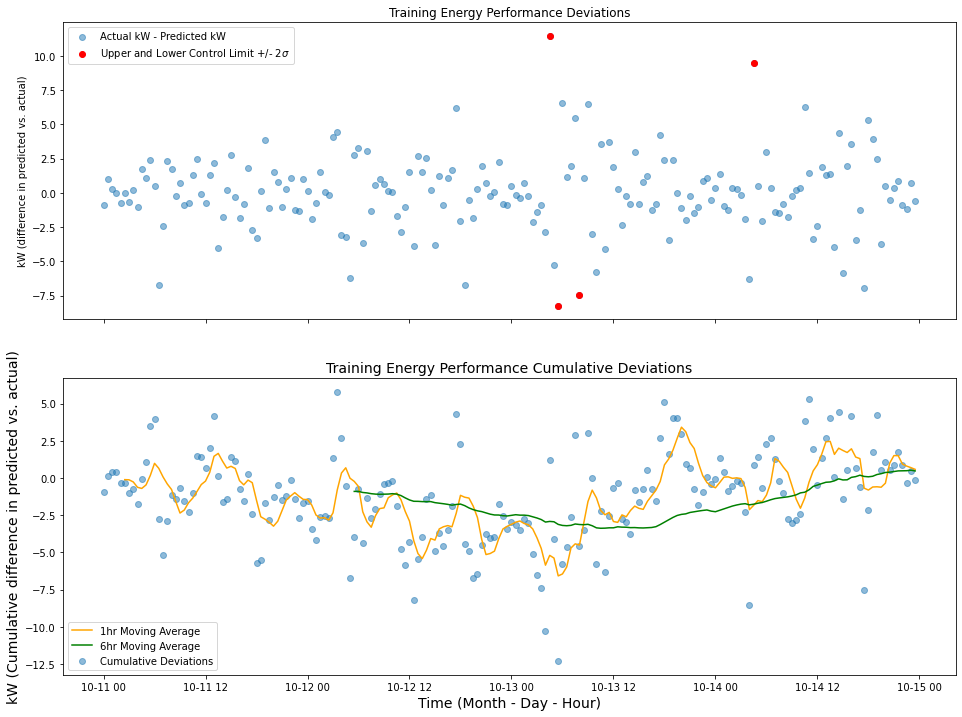

/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:543: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_upper], test_deviation[test_upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:544: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_lower], test_deviation[test_lower], color='red')


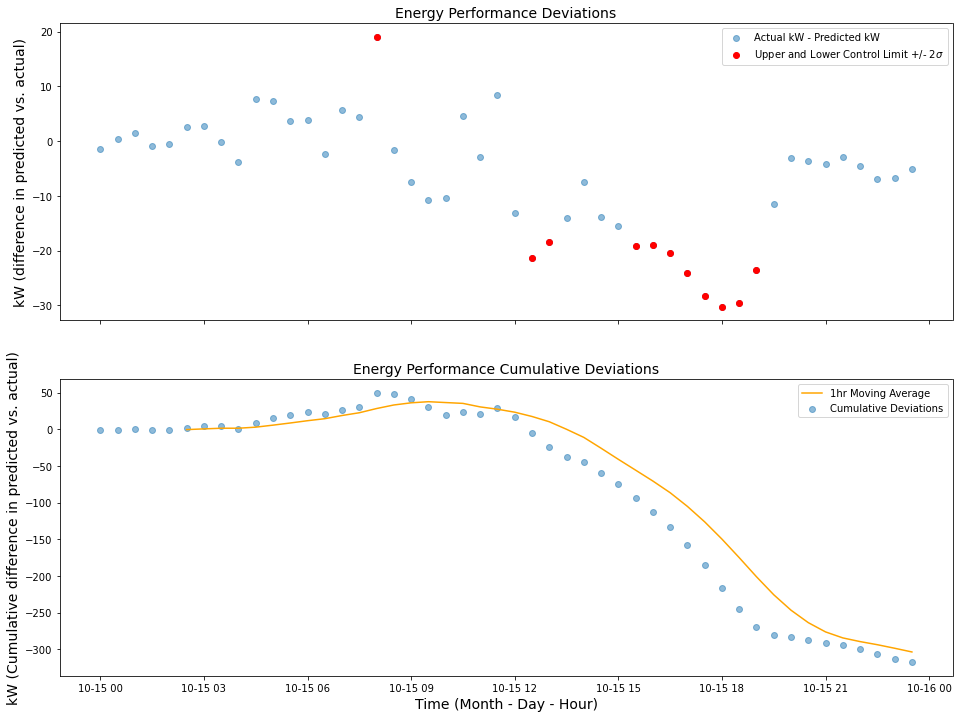

0.7708333333333334 4.8063021241822526


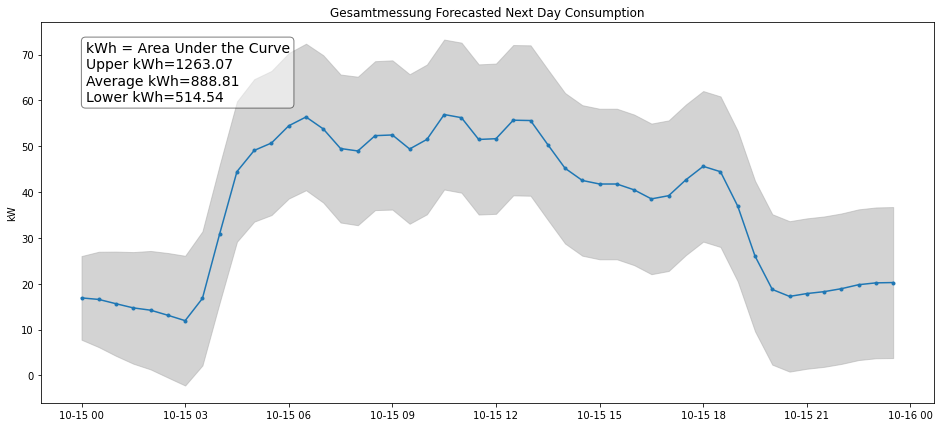

In [13]:
func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module6,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    time_agg='30T',
    training_iter=100,
    lr=0.1,
    machine='Gesamtmessung',
    update_score=False
)

In [15]:
import numpy as np
np.sqrt(mse)

12.773994596750399

In [14]:
mse, mape

(163.17493795780837, 0.44688263257250993)

### 10 minutes agg.

In [16]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='gesamtmessung_10T', 
    freq=10,
    normalize_time=True
    )

In [17]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.07, 0.10) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.19, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


covar_module1 = locally_short_periodic + locally_long_periodic + local_variation 
covar_module2 = locally_short_periodic
covar_module3 = locally_short_periodic + local_variation 
covar_module4 = locally_short_periodic + locally_long_periodic

covar_module5 = locally_long_periodic
covar_module6 = locally_long_periodic + local_variation 

covar_module7 = local_variation

covar_combinations = [
    covar_module1, covar_module2, covar_module3, 
    covar_module4, covar_module5, covar_module6, 
    covar_module7]

In [ ]:
for kernel in covar_combinations:

    X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='gesamtmessung_10T', 
    freq=10,
    normalize_time=True
    )
    
    func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
        kernel_gen=kernel,
        train_x=X_train,
        train_y=y_train,
        test_x=X_test,
        test_y=y_test,
        n_train=n_train,
        training_iter=75,
        lr=0.1,
        time_agg='10T',
        machine='gesamtmessung',
        update_score=True
    )

Iter 1 , Loss = 0.9195603535924936 , Noise = 0.6932471990585327
Iter 2 , Loss = 0.8852495454767831 , Noise = 0.6444966793060303
Iter 3 , Loss = 0.8511982114698594 , Noise = 0.5982182621955872
Iter 4 , Loss = 0.8168954774559934 , Noise = 0.5543885827064514
Iter 5 , Loss = 0.7829059502999924 , Noise = 0.512975811958313
Iter 6 , Loss = 0.7495759032025986 , Noise = 0.47394123673439026
Iter 7 , Loss = 0.7165462124940888 , Noise = 0.4372396171092987
Iter 8 , Loss = 0.6836808496825687 , Noise = 0.402817040681839
Iter 9 , Loss = 0.6514671752671396 , Noise = 0.37061306834220886
Iter 10 , Loss = 0.6204466916040814 , Noise = 0.340565025806427
Iter 11 , Loss = 0.5906962669337652 , Noise = 0.31260859966278076
Iter 12 , Loss = 0.5620534433910684 , Noise = 0.2866746783256531
Iter 13 , Loss = 0.5344317940158037 , Noise = 0.26268714666366577
Iter 14 , Loss = 0.5077333903502073 , Noise = 0.2405632883310318
Iter 15 , Loss = 0.48176712758346935 , Noise = 0.2202148586511612
Iter 16 , Loss = 0.4564892899526

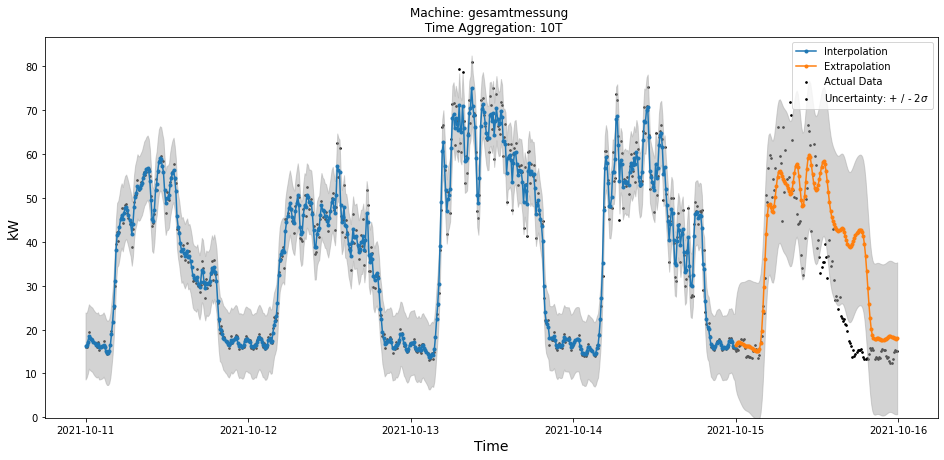

                 time     actual        machine
0 2021-10-13 07:10:00  79.277813  gesamtmessung
1 2021-10-13 07:40:00  78.704534  gesamtmessung


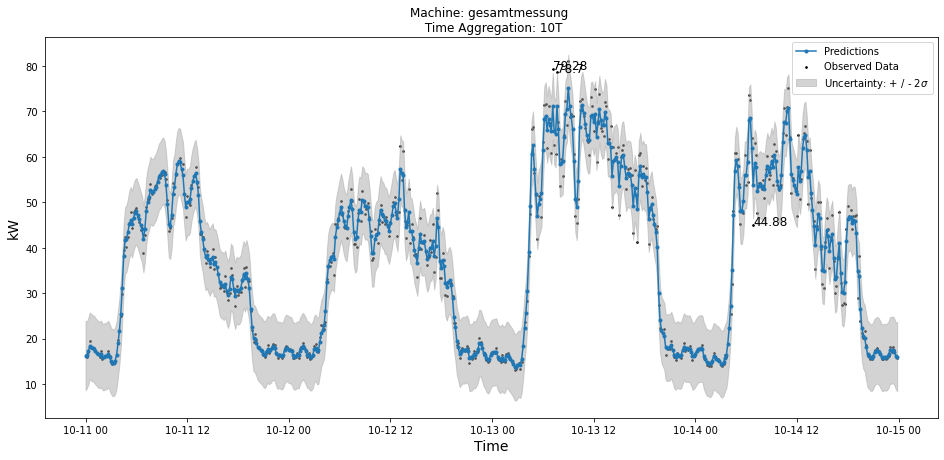

    index                time        machine control_limit  actual_kw  \
0       0 2021-10-15 08:00:00  gesamtmessung         upper  71.971929   
1       1 2021-10-15 08:10:00  gesamtmessung         upper  68.809746   
2       0 2021-10-15 12:20:00  gesamtmessung         lower  36.505573   
3       1 2021-10-15 12:30:00  gesamtmessung         lower  32.959260   
4       2 2021-10-15 12:40:00  gesamtmessung         lower  34.288270   
5       3 2021-10-15 12:50:00  gesamtmessung         lower  35.477738   
6       4 2021-10-15 13:00:00  gesamtmessung         lower  35.457914   
7       5 2021-10-15 13:10:00  gesamtmessung         lower  39.514313   
8       6 2021-10-15 13:20:00  gesamtmessung         lower  36.446612   
9       7 2021-10-15 13:30:00  gesamtmessung         lower  31.679767   
10      8 2021-10-15 15:10:00  gesamtmessung         lower  24.739720   
11      9 2021-10-15 15:30:00  gesamtmessung         lower  23.066486   
12     10 2021-10-15 15:40:00  gesamtmessung       

/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:516: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[upper], deviation[upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:517: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(orig_time[lower], deviation[lower], color='red')


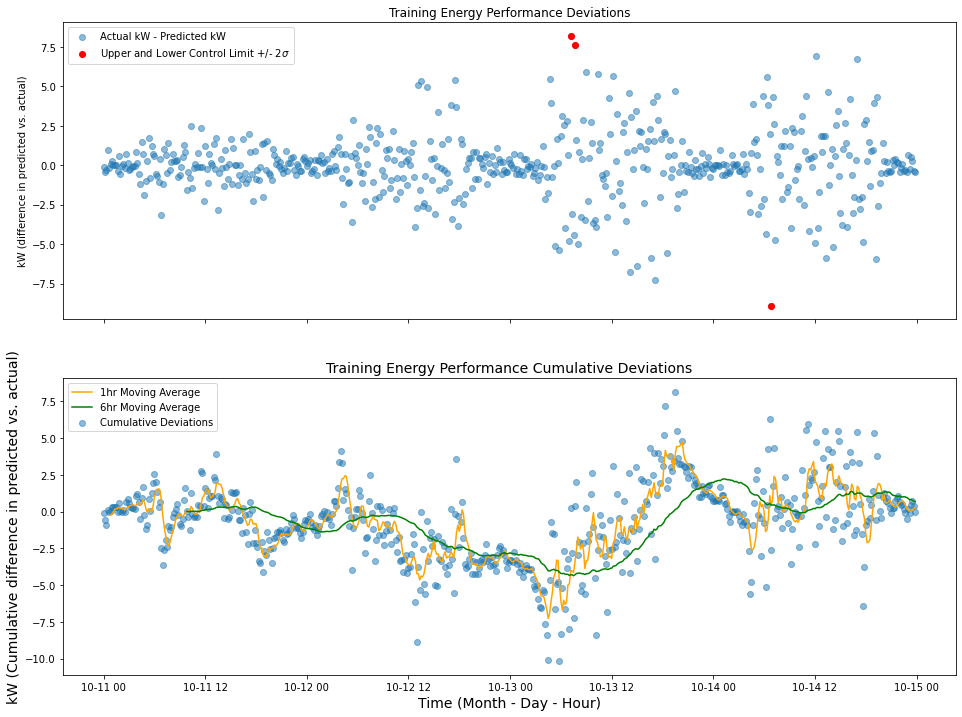

/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:543: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_upper], test_deviation[test_upper], color='red')
/Users/wastechs/Documents/git-repos/energy-efficiency/validation/gp/create_train_inference.py:544: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ax[0].scatter(test_time[test_lower], test_deviation[test_lower], color='red')


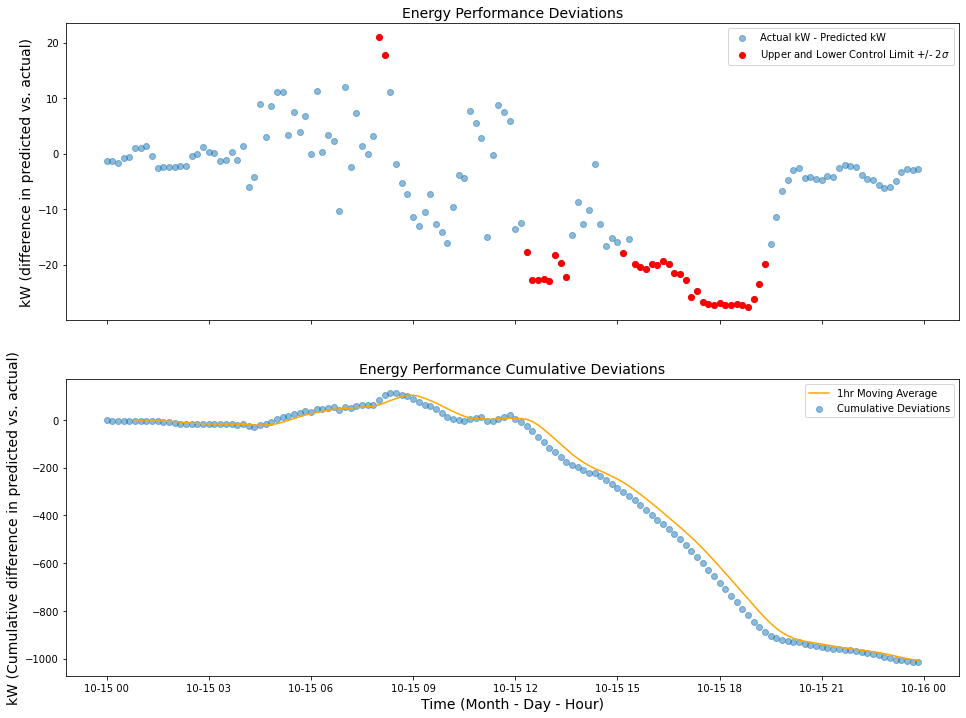

0.7569444444444444 4.912620882333395


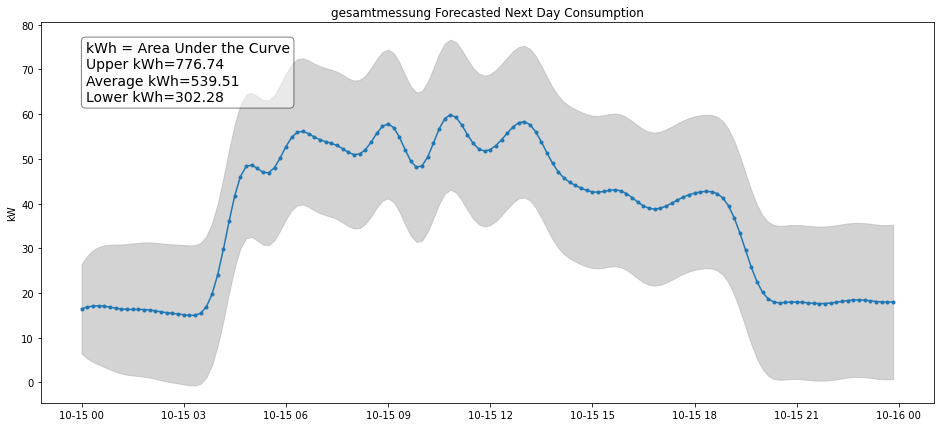

In [18]:
func_preds_mean_inv, func_preds_var_inv, observed_preds, mse, mape = create_train_inference_gp(
    kernel_gen=covar_module1,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=100,
    lr=0.1,
    time_agg='10T',
    machine='gesamtmessung',
    update_score=False)

In [20]:
np.sqrt(mse)

13.013622157909666

In [19]:
mse, mape

(169.35436166883744, 0.4450852125290209)

### 5 minutes

In [ ]:
X_train, y_train, X_test, y_test, n_train = data_preprocessing.gp_preprocess(
    machine='gesamtmessung_5T', 
    freq=5,
    normalize_time=True
    )

In [ ]:
## Locally Periodic Kernel ##
period_constraint_short = gpytorch.constraints.Interval(0.07, 0.10) ## short term

seasonal_periodic_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_short
        )
    )

seasonal_rbf_short = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_short_periodic = seasonal_periodic_short * seasonal_rbf_short

period_constraint_long = gpytorch.constraints.Interval(0.19, 0.21) ## long term

seasonal_periodic_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(
        period_length_constraint=period_constraint_long
        )
    )

seasonal_rbf_long = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel()
)

locally_long_periodic = seasonal_periodic_long * seasonal_rbf_long

## Local Variations ##
local_variation_alpha = gpytorch.priors.GammaPrior(1, 0.5)

local_variation = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RQKernel()
    )
    
local_variation.alpha = local_variation_alpha


covar_module = locally_short_periodic + locally_long_periodic + local_variation

In [ ]:
model, likelihood, mse, mape, perf_dev_upper = create_train_inference_gp(
    kernel_gen=covar_module,
    train_x=X_train,
    train_y=y_train,
    test_x=X_test,
    test_y=y_test,
    n_train=n_train,
    training_iter=75,
    lr=0.05,
    time_agg='5T',
    machine='Gesamtmessung',
    update_score=False
)